[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
from dotenv import load_dotenv

Let's build our agent.

In [2]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

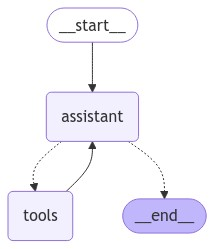

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [6]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption (stream_mode="values" -> full state)
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_EM6SaS1VM76rshX8TuVHshfx)
 Call ID: call_EM6SaS1VM76rshX8TuVHshfx
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [7]:
theState = graph.get_state({'configurable': {'thread_id': '1'}})
print(theState.values['messages'])
for m in theState.values['messages']:
    print(m)

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EM6SaS1VM76rshX8TuVHshfx', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8eb6cac-cebf-4adf-97e2-637626922a1c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_EM6SaS1VM76rshX8TuVHshfx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 18, 'total_to

In [28]:
print(theState.config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd497c-0004-6525-8003-76781cd8cf50'}}


We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [8]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
for s in all_states:
    print(s.config['configurable']['checkpoint_id'])

1efd9a64-a576-6482-8003-85068fb83982
1efd9a64-9d54-6be8-8002-a9738afa26b1
1efd9a64-9d3e-6136-8001-f26ccbd9d348
1efd9a64-8ba2-65ed-8000-18a6e6b3e9ee
1efd9a64-8b9b-667d-bfff-0b889ebbe79e


The first element is the current state, just as we got from `get_state`.

In [11]:
dir(all_states[0])

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_fields',
 '_make',
 '_replace',
 'config',
 'count',
 'created_at',
 'index',
 'metadata',
 'next',
 'parent_config',
 'tasks',
 'values']

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [12]:
to_replay = all_states[-2]

In [13]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd9a64-8ba2-65ed-8000-18a6e6b3e9ee'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}}, created_at='2025-01-23T16:22:47.973191+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd9a64-8b9b-667d-bfff-0b889ebbe79e'}}, tasks=(PregelTask(id='44816f95-94a3-e619-8e51-13c8c280205b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

Look at the state.

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]}

We can see the next node to call.

In [15]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [16]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9a64-8ba2-65ed-8000-18a6e6b3e9ee'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [17]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ubx8FNpoFoEYv9jHGayLZIZX)
 Call ID: call_ubx8FNpoFoEYv9jHGayLZIZX
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [18]:
to_fork = all_states[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]

Again, we have the config.

In [19]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9a64-8ba2-65ed-8000-18a6e6b3e9ee'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [20]:
# This overwrites the first messages
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]}
)

In [21]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd9a8d-3086-638a-8001-f79f12b96920'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [22]:
all_states = [state for state in graph.get_state_history(thread)]
all_states[0].values['messages']

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]

In [23]:
graph.get_state({"configurable": {"thread_id": "1"}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd9a8d-3086-638a-8001-f79f12b96920'}}, metadata={'source': 'update', 'step': 1, 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2')]}}, 'parents': {}}, created_at='2025-01-23T16:40:59.004998+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd9a64-8ba2-65ed-8000-18a6e6b3e9ee'}}, tasks=(PregelTask(id='128a3f06-904c-5530-16bd-482f1554e1a1', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None),))

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [24]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Z4w6MC4U46bejj9F8lvlnPdN)
 Call ID: call_Z4w6MC4U46bejj9F8lvlnPdN
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


Now, we can see the current state is the end of our agent run.

In [27]:
latest_state = graph.get_state({'configurable': {'thread_id': '1'}})
print(latest_state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='a78d21c9-fcbc-445c-9b06-48beb2f62be2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z4w6MC4U46bejj9F8lvlnPdN', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 131, 'total_tokens': 149, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-997e3532-9a0e-4ec8-b262-73b61e037e7b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_Z4w6MC4U46bejj9F8lvlnPdN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1